## This notebook looks to read an image and bound the ID. The bounded ID is padded, thresholded and cleaned. 

In [1]:
from google.cloud import vision
import os

import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

from helpers.corrections import *
from helpers.image_loading import * 
from helpers.handling import *
from helpers.identity_isolation import * 

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"
client = vision.ImageAnnotatorClient()

In [2]:
random_files = ListAvaliableFiles('guppy_images', prefix='Manually_Labelled/New', verbose=False)
np.random.shuffle(random_files)

In [3]:
def combine_boxes(boxes, verbose=False):
    # Given a list of boxes, combines them into a single box that spans from (x_min, y_min) to (x_max, y_max).
    X_points = []
    Y_points = []
    for box in boxes:
        for vertex in box:
            X_points.append(vertex[0])
            Y_points.append(vertex[1])

    X_points = np.sort(np.array(X_points))
    Y_points = np.sort(np.array(Y_points))

    number_of_points = len(Y_points)

    X_Low = X_points[:number_of_points//2]
    X_High = X_points[number_of_points//2:]
    Y_Low = Y_points[:number_of_points//2]
    Y_High = Y_points[number_of_points//2:]

    Y_min = np.mean(Y_Low)
    Y_max = np.mean(Y_High)

    if len(boxes) == 3:
        if verbose: print('Only three bounding boxes - elongating box.')
        X_min = X_points.min() - 80
        X_max = X_points.max() + 80

    else:
        X_min = X_points.min()
        X_max = X_points.max()

    para_box = np.zeros((4,2), dtype=np.int32)

    para_box[0] = [X_min, Y_min]
    para_box[1] = [X_max, Y_min]
    para_box[2] = [X_max, Y_max]
    para_box[3] = [X_min, Y_max]

    return para_box

F pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
character: F upper height: 441 lower height: 337
L pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:1
character: L upper height: 441 lower height: 337
L pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:2
character: L upper height: 441 lower height: 337
T pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:0
character: T upper height: 627 lower height: 450
U pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:1
character: U upper height: 625 lower height: 447
G pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:2
character: G upper height: 623 lower height: 445
Y pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:3
character: Y upper height: 621 lower height: 443
4 pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:0
character: 4 upper height: 767 lower height: 670
/ pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:1
character: / upper height: 767 lower height: 670
2 pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:2
character

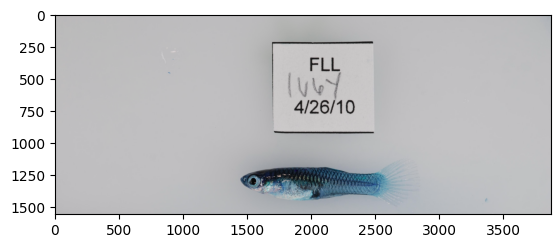

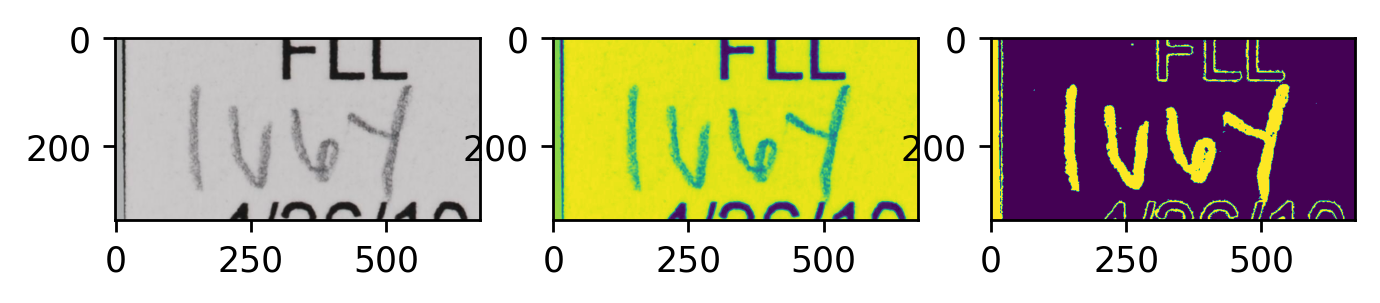

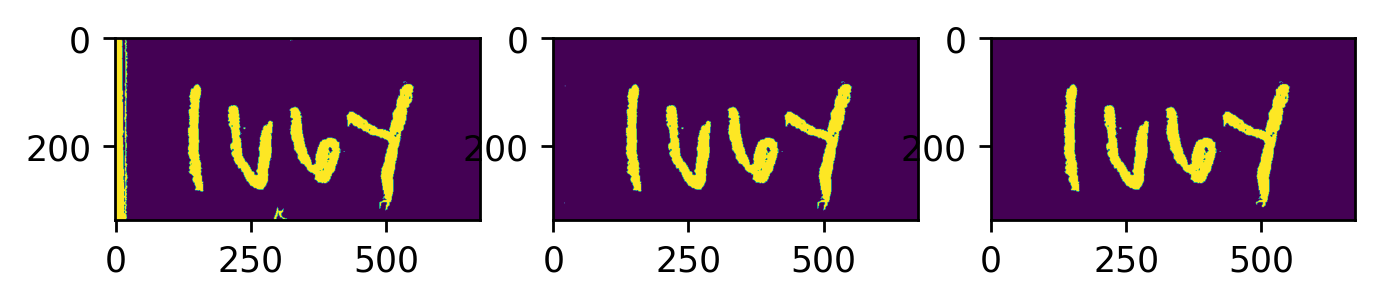

In [4]:
# Collect image from bucket
image_in_bytes = RetreiveImage(random_files[38])

# Read image and return initial output, frame and identity character boxes
output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=True)

# Collect character boxes into a singe ID box.
identity_box = combine_boxes(character_boxes)

padx = 100
pady = 80
# Reduce the image to just the ID
reduced_frame = reduce_image(frame, identity_box, padx=padx, pady=pady)

# Mask and remove for final image
masked_image = mask_and_remove(reduced_frame, verbose = True)

# Remove deltas
final_image = remove_deltas(masked_image, width=15, padx=padx, pady=pady//2, verbose = True)

print(output_string)

In [5]:
shape = np.shape(final_image)
counts = np.count_nonzero(final_image)
counts, shape[0] * shape[1], counts / (shape[0] * shape[1])

(20672, 226800, 0.09114638447971782)

In [6]:
shape

(336, 675)

Manually_Labelled/New/CA1212 JB/FCA4R7O1212.JPG


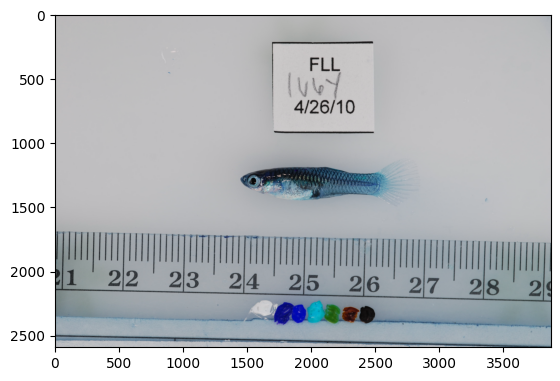

In [7]:
decoded = np.frombuffer(image_in_bytes.getvalue(), dtype=np.uint8)
frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR) 
plt.imshow(frame)
print(random_files[8])

(upper thresh, lower_thresh) = (192.60, 36.33)


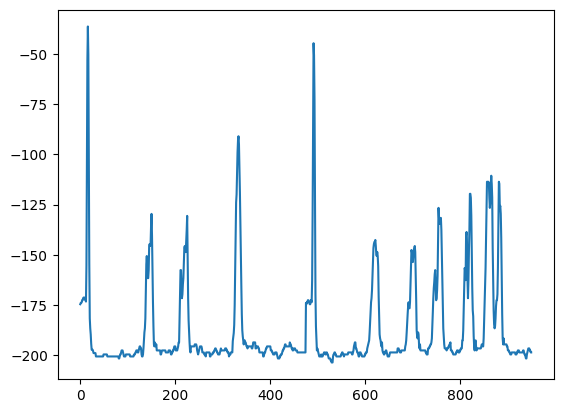

In [8]:
# Average out the RGB axis
averaged_frame = np.mean(reduced_frame,axis=2)

# White background masking
hist = np.histogram(averaged_frame, bins=100)
centers = 0.5*(hist[1][1:]+ hist[1][:-1])

thresh_val = np.argmax(hist[0] > np.max(hist[0]) * 0.2)
upper_thresh = centers[thresh_val] * 0.975

# Dark writing masking. Mask based on central row of frame
frame_shape = np.shape(averaged_frame)
row1 = -averaged_frame[2 * frame_shape[0] // 5][00:-200]
row2 = -averaged_frame[3 * frame_shape[0] // 5][00:-200]
rows = np.concatenate((row1, row2))
# rows = row2 = -averaged_frame[1]
row_mean = np.mean(rows)
row_max = np.max(rows)
row_min = np.min(rows)
peaks,_ = scipy.signal.find_peaks(rows, height = row_mean + ((row_max - row_min) / 5), distance=4)

values = []
for peak in peaks:
    values.append(-rows[peak])

sorted_values = np.sort(values)

lower_thresh = sorted_values[0] * 1

averaged_frame[averaged_frame>upper_thresh] = 0
averaged_frame[averaged_frame<lower_thresh] = 0
averaged_frame[averaged_frame!=0] = 255

plt.plot(rows)
# plt.imshow(averaged_frame)
print('(upper thresh, lower_thresh) = (%.2f, %.2f)' %(upper_thresh, lower_thresh))

192.6015

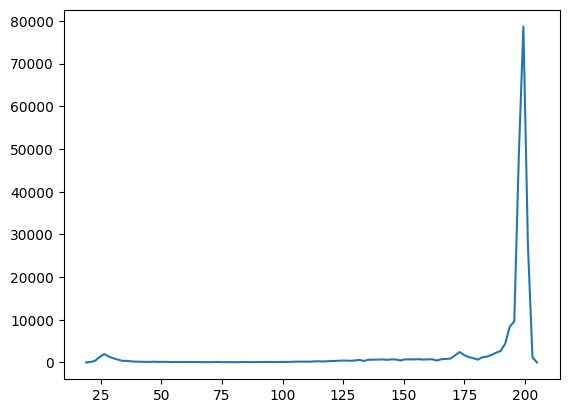

In [9]:
averaged_frame = np.mean(reduced_frame,axis=2)

# White background masking
hist = np.histogram(averaged_frame, bins=100)
centers = 0.5*(hist[1][1:]+ hist[1][:-1])

thresh = np.argmax(hist[0] > np.max(hist[0]) * 0.2)
upper_thresh = centers[thresh_val] * 0.975

# averaged_frame = np.mean(reduced_frame,axis=2)
# hist = np.histogram(averaged_frame, bins=1000)
# centers = 0.5*(hist[1][1:]+ hist[1][:-1])

# thresh = np.argmax(hist[0] > np.max(hist[0]) * 0.2)
# centers[thresh] * 0.975

plt.plot(centers, hist[0])
centers[thresh] * 0.975

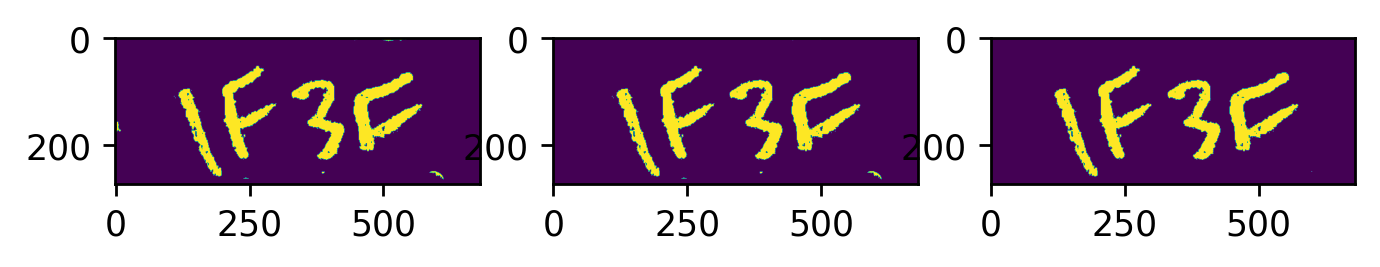

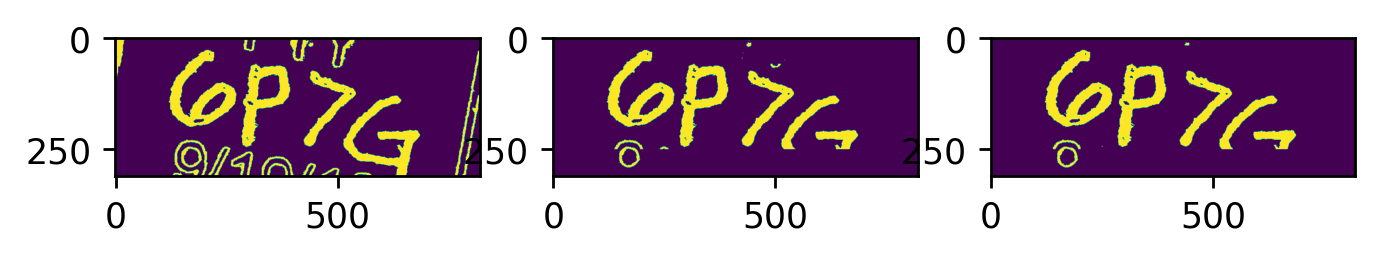

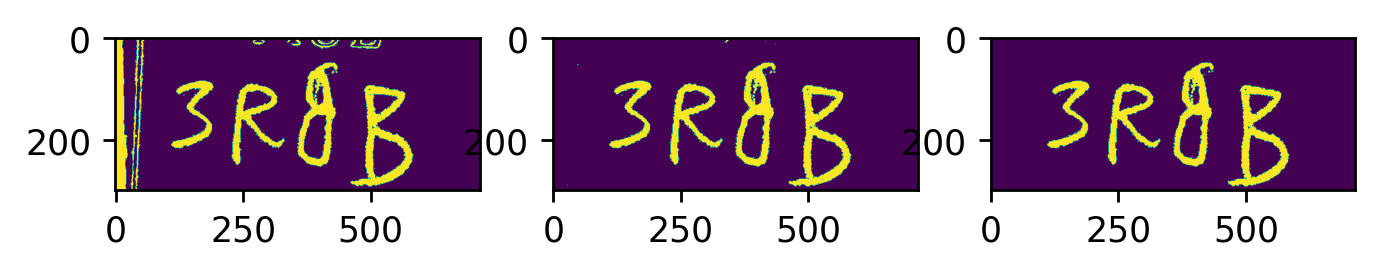

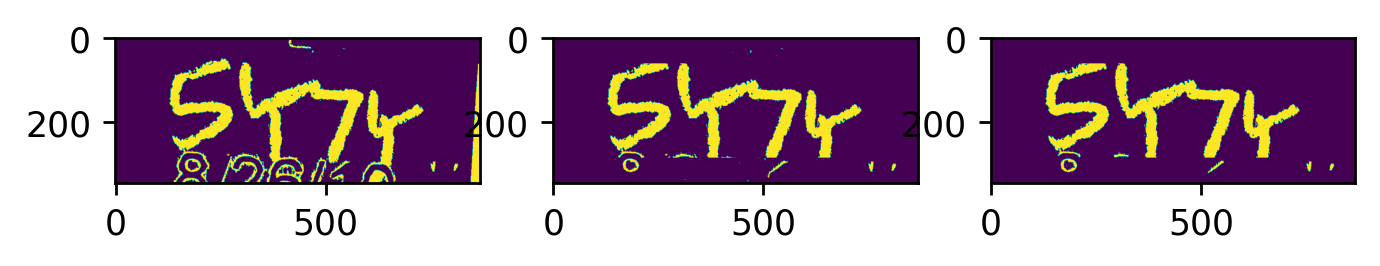

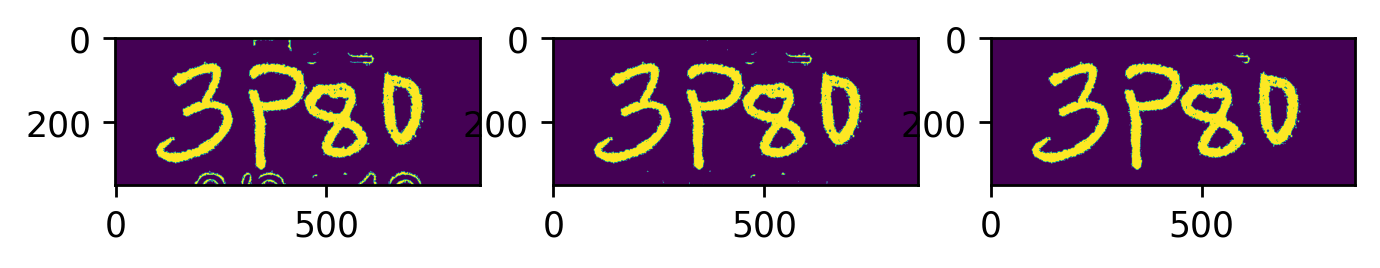

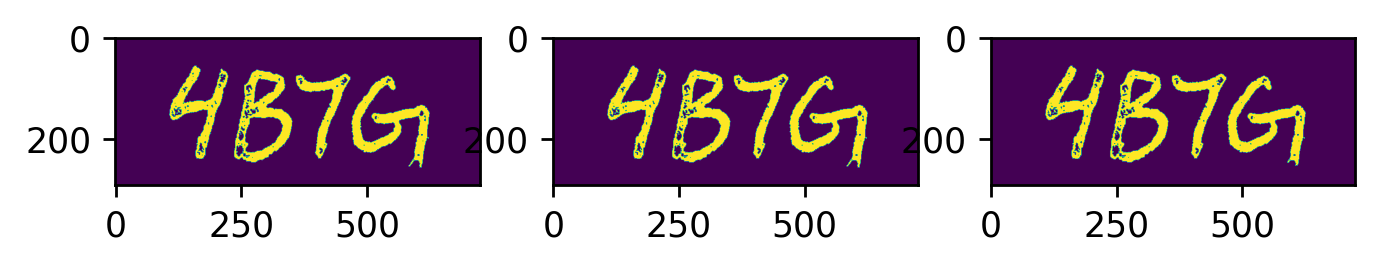

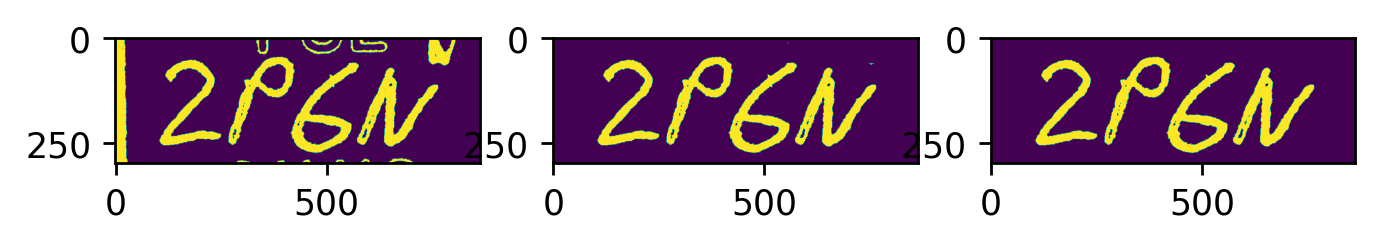

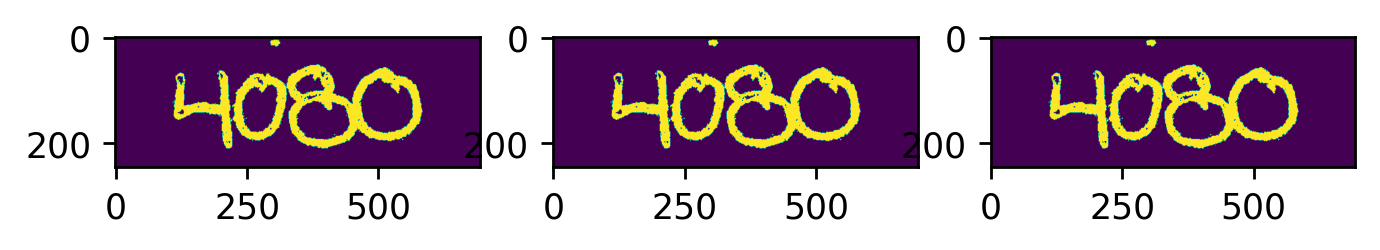

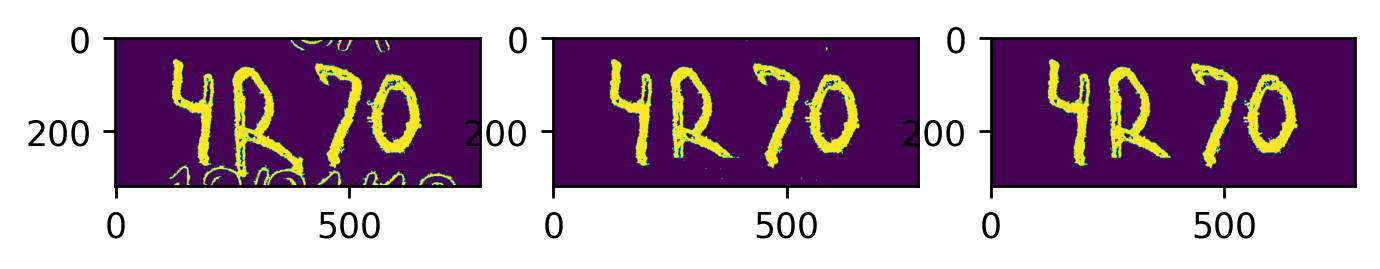

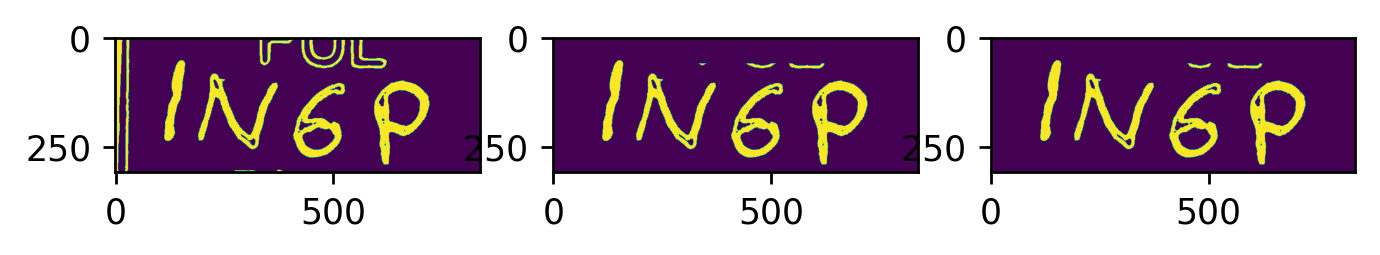

In [10]:
%matplotlib inline
padx = 100
pady = 60
for i in range(10):
    try:
        # Collect image from bucket
        image_in_bytes = RetreiveImage(random_files[i])

        # Read image and return initial output, frame and identity character boxes
        output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=False)

        # Collect character boxes into a singe ID box.
        identity_box = combine_boxes(character_boxes)

        # Reduce the image to just the ID
        reduced_frame = reduce_image(frame, identity_box, padx=padx, pady=pady)

        # Mask and remove for final image
        masked_image = mask_and_remove(reduced_frame, verbose = False)

        # Remove deltas
        final_image = remove_deltas(masked_image, width=10, padx=padx, pady=pady, verbose = True)
    
    except:
        pass

M pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
character: M upper height: 156 lower height: 28
L pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:1
character: L upper height: 158 lower height: 31
L pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:2
character: L upper height: 160 lower height: 33
I pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:0
character: I upper height: 372 lower height: 205
B pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:1
character: B upper height: 379 lower height: 209
6 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:2
character: 6 upper height: 385 lower height: 216
V pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:3
character: V upper height: 393 lower height: 223
7 pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:0
character: 7 upper height: 533 lower height: 411
/ pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:1
character: / upper height: 534 lower height: 413
2 pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:2
character: 2

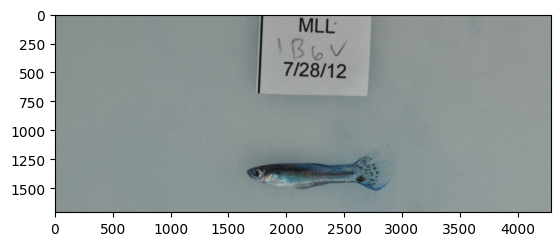

In [11]:
# Collect image from bucket
image_in_bytes = RetreiveImage(random_files[102])

# Read image and return initial output, frame and identity character boxes
output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=True)

# Collect character boxes into a singe ID box.
identity_box = combine_boxes(character_boxes)

In [12]:
client = vision.ImageAnnotatorClient()
fig,ax = plt.subplots(10,20, figsize=(20,20))
padx = 100
pady = 80

i = 0
j = 0

while i < 200:
    try:
        # Collect image from bucket
        image_in_bytes = RetreiveImage(random_files[j])

        # Read image and return initial output, frame and identity character boxes
        output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=False)

        # Collect character boxes into a singe ID box.
        identity_box = combine_boxes(character_boxes)

        # Reduce the image to just the ID
        reduced_frame = reduce_image(frame, identity_box, padx=padx, pady=pady)

        # Mask and remove for final image
        masked_image = mask_and_remove(reduced_frame, verbose = False)

        # Remove deltas
        final_image = remove_deltas(masked_image, width=15, padx=padx, pady=pady//2, verbose = False)

        shape = np.shape(final_image)
        counts = np.count_nonzero(final_image)
        valid_test = counts / (shape[0] * shape[1])

        if valid_test > 0.04 and shape[0] > 250 and shape[1] < 1000:
            ax[i // 10, i % 10].imshow(final_image)
            ax[i // 10, i % 10].set_title('index %i' %j)

            i += 1
            j += 1
            print(j)

        else:
            j += 1
            
    except:
        j += 1
        pass

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
